# PART - 1
  ## Loading the raw data 

In [1]:
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

# Read the last lines because they are "closer" time-wise to the test set.
train = pd.read_csv("D:/input/train.csv", 
                    skiprows=range(1,153903891),
                    nrows=30000000,
                    usecols=train_columns, dtype=dtypes)
test = pd.read_csv("D:/input/test.csv" , usecols=test_columns, dtype=dtypes)
validation = pd.read_csv("D:/input/train.csv" , nrows = 10000000 , usecols=train_columns , dtype = dtypes)


## Preprocessing and feature engineering

In [28]:
import gc
import time

def prep_data(df):
    print("Creating new time features: 'hour' , 'day', 'minutes' , 'secondes'...")
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('uint8')
    df['minute'] = pd.to_datetime(df.click_time).dt.minute.astype('uint8')
    df['seconde'] = pd.to_datetime(df.click_time).dt.second.astype('uint8')
    
    print("Feature Engineering \n")
    
    print('1. Computing the number of clicks associated with a given IP address within each hour... ')
    temp = df[['ip','day','hour','channel']].groupby(by=['ip','day',
          'hour'])[['channel']].count().reset_index().rename(columns={'channel': 'hourly_clicks'})

    df = df.merge(temp, on=['ip','day','hour'], how='left')
    del temp
    gc.collect()
    print('1. Computing the number of clicks associated with a given IP address within each minute... ')
    temp = df[['ip','day','hour','minute','channel']].groupby(by=['ip','day',
          'hour','minute'])[['channel']].count().reset_index().rename(columns={'channel': 'click_per_minute'})
    
    df = df.merge(temp, on=['ip','day','hour','minute'], how='left')
    del temp
    gc.collect()
    print('1. Computing the number of clicks associated with a given IP address within each seconde... ')
    temp = df[['ip','day','hour','minute','seconde','channel']].groupby(by=['ip','day',
          'hour','minute','seconde'])[['channel']].count().reset_index().rename(columns={'channel': 'click_per_seconde'})
    
    df = df.merge(temp, on=['ip','day','hour','minute','seconde'], how='left')
    del temp
    gc.collect()
          
          
    print('2. Computing the number of clicks associated with a given IP address and app...')
    n_channel = df[['ip','app', 'channel']].groupby(by=['ip', 
          'app'])[['channel']].count().reset_index().rename(columns={'channel': 'ip_app_count'})
    
    df = df.merge(n_channel, on=['ip','app'], how='left')
    del n_channel
    gc.collect()
    print('3. Computing the number of clicks associated with a given IP address, app, and os...')
    n_channel = df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 
          'os'])[['channel']].count().reset_index().rename(columns={'channel': 'ip_app_os_count'})       
    df = df.merge(n_channel, on=['ip','app', 'os'], how='left')
    del n_channel
    gc.collect()
        
    df['hourly_clicks'] = df['hourly_clicks'].astype('uint16')
    df['ip_app_count'] = df['ip_app_count'].astype('uint16')
    df['ip_app_os_count'] = df['ip_app_os_count'].astype('uint16')
    df['click_per_seconde'] = df['click_per_seconde'].astype('uint16')
    df['click_per_minute'] = df['click_per_minute'].astype('uint16')
   
    df.drop(['click_time','day'], axis=1, inplace=True )
    gc.collect()
    from sklearn.preprocessing import LabelEncoder
    df[['app','device','os', 'channel', 'hour']].apply(LabelEncoder().fit_transform)
    
    return df
print('started preparing the data')
start_time = time.time()
print('preparing train data')
train = prep_data(train)
print('preparing test data')
test = prep_data(test)
print('preparing validation data')
validation = prep_data(validation)
print("finished in %0.2f minute" % (((time.time()-start_time)/60)))

started preparing the data
preparing train data
Creating new time features: 'hour' , 'day', 'minutes' , 'secondes'...
Feature Engineering 

1. Computing the number of clicks associated with a given IP address within each hour... 
Merging the channels data with the main data set...

1. Computing the number of clicks associated with a given IP address within each minute... 
Merging the channels data with the main data set...

1. Computing the number of clicks associated with a given IP address within each seconde... 
Merging the channels data with the main data set...

2. Computing the number of clicks associated with a given IP address and app...
Merging the channels data with the main data set...

3. Computing the number of clicks associated with a given IP address, app, and os...
Merging the channels data with the main data set...

preparing test data
Creating new time features: 'hour' , 'day', 'minutes' , 'secondes'...
Feature Engineering 

1. Computing the number of clicks associate

In [19]:
import gc
import numpy as np
X = train.drop('is_attributed' , axis =1)
y = train['is_attributed']
y = np.ravel(y)
del train
gc.collect()


89

# Finding the best hyperparametres for our classifiers

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()
gbc_clf = GradientBoostingClassifier()
rf_clf = RandomForestClassifier()

clfs=[lr_clf,dt_clf, gbc_clf, rf_clf]


LogisticPredictors = list(X) - ['ip']

In [16]:
def best_hyperparams(clf, params, X, y, score,nsplit,random_state):
    skf=StratifiedKFold(n_splits=nsplit)
    clf = GridSearchCV(clf, param_grid=params, cv=skf,scoring=score  ,n_jobs=4)
    
    clf.fit(X, y)
    print("The best parameters are %s with an average score over 5 folds of %0.2f"
      % (clf.best_params_, clf.best_score_))
    
    print('the best estimator',clf.best_estimator_)
    return clf.best_estimator_

In [10]:
import numpy as np
parameters = [
    [{'C':np.logspace(-3, 3, 10),'solver':['saga','liblinear'] ,'penalty':['l1','l2']}],#LogisticRegression
    #[{'C':np.logspace(-2, 10, 5),'gamma':np.logspace(-2, 1, 3) ,'kernel':['rbf']}],#SVM
    #[{'n_neighbors': [3,5,10,20,50]}], # KNN
    [{'criterion':['gini','entropy'],"min_samples_split": [150,300,600,1200]}], # DecisionTree
    [{'n_estimators': [25, 50, 75, 100, 150,200], 'learning_rate': [0.001,.01,.05,.1], 'max_depth': [1,2,3]}], # GBC
    [{'n_estimators': [50,100,150,200], 'max_depth': [5,7,9,15,22]}] # RF
] 

In [18]:
import time
start_time = time.time()
score = 'roc_auc'
nsplit=5
random_state=42
best_models=[]
for clf,params in zip(clfs,parameters):
    start_time = time.time()
    best_models.append(best_hyperparams(clf,params,X, y, score,nsplit,random_state))
    print('done in %0.2f hours' % (((time.time() - start_time)/3600)))
    print('-'*100)



The best parameters are {'C': 46.415888336127729, 'penalty': 'l1', 'solver': 'liblinear'} with an average score over 5 folds of 0.83
the best estimator LogisticRegression(C=46.415888336127729, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
done in 4.65 hours
----------------------------------------------------------------------------------------------------
The best parameters are {'criterion': 'entropy', 'min_samples_split': 600} with an average score over 5 folds of 0.94
the best estimator DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=600,
            min_weight_fraction_leaf=0.0, presort=False, rand

# Dimentiality Reduction

Text(0.5,1,'PVE by number of components')

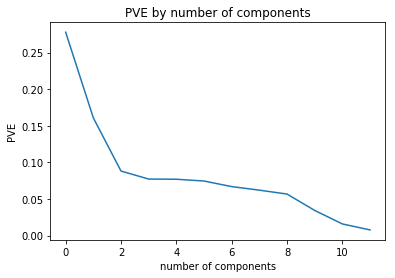

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca_red = PCA(n_components=12)
X2= scaler.fit_transform(X)
pca_red.fit(X2)
plt.plot(pca_red.explained_variance_ratio_ )
plt.xlabel('number of components')
plt.ylabel('PVE')
plt.title('PVE by number of components')

In [36]:
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([
    ('reduce_dim', pca),
    ('knn', knn_clf)])

start_time = time.time()
param_grid = dict(reduce_dim__n_components=[2,3,5,8,10], knn__n_neighbors=[5,10,15,20])
grid = GridSearchCV(pipe, cv=5, n_jobs=-1, param_grid=param_grid)
grid.fit(X,y)
best_models.append(grid.best_estimator_)
print('best params for PCA+KNN are: %s with a score of %s ' %(grid.best_params_, grid.best_score_))
print('done in %0.2f hours' % ((time.time() - start_time)/3600)

best params for PCA+KNN are: {'knn__n_neighbors': 15, 'reduce_dim__n_components': 8} with a score of 0.91
done in 8.07 hours


In [29]:
Ids = test['click_id']
test_id = test.drop('click_id', axis = 1)
del test
gc.collect()

lr_sub = pd.DataFrame()
knn_sub = pd.DataFrame()
dt_sub = pd.DataFrame()
gbm_sub=pd.DataFrame()
rf_sub=pd.DataFrame()

subs = [lr_sub,knn_sub,dt_sub,gbm_sub,rf_sub]
names = ['LogisticRegression','KNN','DecisionTree','GBM','RandomForest']


def predict_and_submit(clf , test_df , sub , name):
    sub['click_id'] = Ids
    print("Predicting using the best estimator found for %s" % name)
    sub['is_attributed'] = clf.predict_proba(test_df)[:,1]
    print("writing the csv file...")
    sub.to_csv('sub_%s.csv'%(name),index=False,float_format='%.9f')
    del sub
    gc.collect()

In [37]:
lr_sub = pd.DataFrame()
dt_sub = pd.DataFrame()
gbm_sub=pd.DataFrame()
rf_sub=pd.DataFrame()
knn_sub = pd.DataFrame()

subs = [lr_sub,dt_sub,gbm_sub,rf_sub,knn_sub]
names = ['LogisticRegression','DecisionTree','GBM','RandomForest','KNN_pca']
i=0
for trained_model,sub,name in zip(best_models,subs,names):
    start_time = time.time()
    predict_and_submit(trained_model,test_id,sub,name)
    print("done in %0.2f minutes" % (((time.time()-start_time)/60)))
    
    

Predicting using the best estimator found for LogisticRegression
writing the csv file...
done in 4.91 minutes
Predicting using the best estimator found for DecisionTree
writing the csv file...
done in 4.76 minutes
Predicting using the best estimator found for GBM
writing the csv file...
done in 5.01 minutes
Predicting using the best estimator found for RandomForest
writing the csv file...
done in 7.57 minutes
Predicting using the best estimator found for KNN_pca
writing the csv file...
done in 15.13 minutes


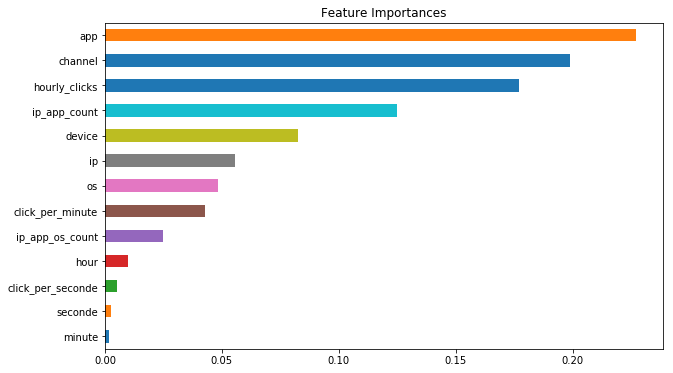

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,6))
plt.title('Feature Importances')
feat_importances = pd.Series(clf_rf.feature_importances_, index=X.columns).sort_values()
feat_importances.plot(kind='barh')
plt.show()

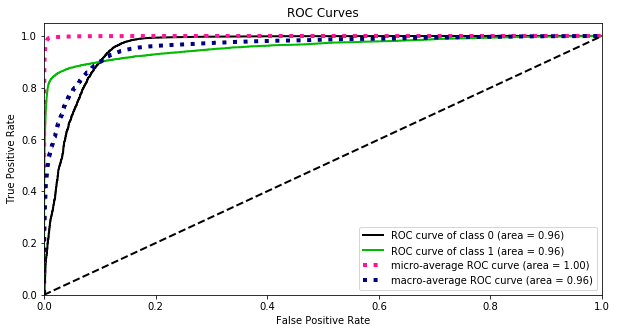

In [109]:

import scikitplot as skplt
import matplotlib.pyplot as plt

validation = pd.read_csv("D:/input/train.csv" ,skiprows=range(1,120000000), nrows = 20000000 , usecols=train_columns, dtype=dtypes)
validation = prep_data(validation)
y_true = validation['is_attributed']
validation.drop('is_attributed' , axis = 1 , inplace=True)
y_probas = clf_rf.predict_proba(validation)
skplt.metrics.plot_roc_curve(y_true, y_probas , figsize=(12,6 ))

# LightGBM

In [72]:
from sklearn.model_selection import GridSearchCV
import time
parameters = [{
    'learning_rate': [0.05,0.1,0.15],
    'num_leaves': [5,6,7],  # lower than 2^max_depth - 1
    'max_depth': [2,3,4],  # -1 means no limit
    'num_boost_round' : [300,500,700], # number of iterations ( trees )
    'scale_pos_weight':[99.82], # because training data is extremely unbalanced 
}]  
start_time = time.time()
predictors = ['app','device','os', 'channel', 'hour', 
              'hourly_clicks','click_per_minute','click_per_seconde','ip_app_count','ip_app_os_count']
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day' ,'minute','seconde']

clf_lgb = lgb.LGBMClassifier(objective='binary',metrics='auc' , categorical_feature=[1,2,3,4,5,6],feature_name=predictors)
grid = GridSearchCV(clf_lgb, cv=5, n_jobs=4, param_grid=parameters)
grid.fit(X,y)
print("The best parameters are %s with an average score over 5 folds of %0.4f" % (grid.best_params_, grid.best_score_))
    
print('done in %0.2f hours' % ((time.time() - start_time)/3600))

The best parameters are {'learning_rate': 0.15, 'max_depth': 3, 'num_boost_round': 500, 'num_leaves': 7, 'scale_pos_weight': 99.82} with an average score over 5 folds of 0.9900
done in 10.81 hours


In [113]:
 predict_and_submit(clf_lgb,test_id,'gbm','lightgbm_FinalVersion')

Predicting using the best estimator found for lightgbm_FinalVersion
writing the csv file...
done in 3.91 minutes
